Model orthogonalization with LDM variants. This is an interactive jupyter notebook, that contains the following model scenarios:

* 4 classes, 2 models of each class
* 1 good model 7 bad models
* 4 good models 4 bad models
* 7 good models 1 bad model
* 1 model perfect 7 models bad

These scenarios are examined using PCA. One needs to make some choices when analyzing the scenarios, which in turn yields the following PCA variants:

* Raw model output  -  not standardized
* Raw model output  -  staandardized
* Residuals - not standardized
* Residuals - standardized

Example: Let's say you are interested in the scenario with **1 model perfect 7 models bad** and you want to analyze **standardized residuals**, then you need to run the code chunks under the **following headings**:

1. Utilities
2. Scenario - 1 model perfect 7 models bad
3. Residuals - standardized

This is the code hierarchy:

    ├── Utilities
    └── Version 2.0 - LDM variants
        ├── 4 classes, 2 models of each class
        ├── 1 good model 7 bad models
        ├── 4 good models 4 bad models
        ├── 7 good models 1 bad model
        ├── 1 model perfect 7 models bad
    └── PCA - Analysis
        ├── Raw model output  -  not standardized
        ├── Raw model output  -  staandardized
        ├── Residuals - not standardized
        ├── 7 good models 1 bad model
        ├── Residuals - standardized
        
**I recommend to have Collapsible Headings nbextension active for the best experience.**

## Utilities

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def LDM_extended(params, x):
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)
    #I = 0

    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4)
    
LDM_truth_params=[14,13.3,0.57,17]

def Truth(x):
    return LDM(LDM_truth_params,x)

#We should create the data (paris of [N,Z])
def data_loader():
    input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
    input_NZ.columns = ["N", "Z"]
    return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    return

### Global variables####

# SkO values selected for the truth
truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5]

# SLy4 values selected for the truth
SLY_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1]
# NL_1 params
NL1_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3]
corruption_noise_Mass=1/3

c1_params = [SLY_params, NL1_params]
c2_params = [[-15.972, 18.4, 9, 32.01, -54, 0], [-16.425, 18.8, 9, 43.48, -110, 0]]
c3_params = [[-15.972, 18.4, 9, 32.01, 0, 0], [-16.425, 18.8, 9, 43.48, 0, 0]]
c4_params = [[-15.972, 18.4, 9, 0, 0, 0], [-16.425, 18.8, 9, 0, 0, 0]]

##########################

## Version 2.0 - LDM variants

### Scenario - 4 classes, 2 models of each class

In [3]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
scenario = "original"

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 2
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

# Model class 2: truth + quadratic distortion + noise
n_class_2 = 2
params = c2_params
for i in range(n_class_2):
    models_output["c2_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])
    
n_class_3 = 2
params = c3_params
for i in range(n_class_3):
    models_output["c3_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 2
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

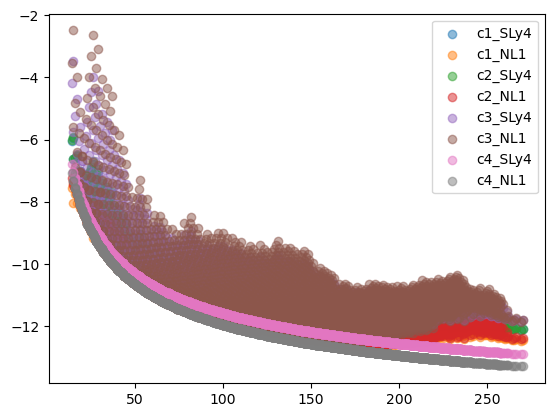

In [4]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

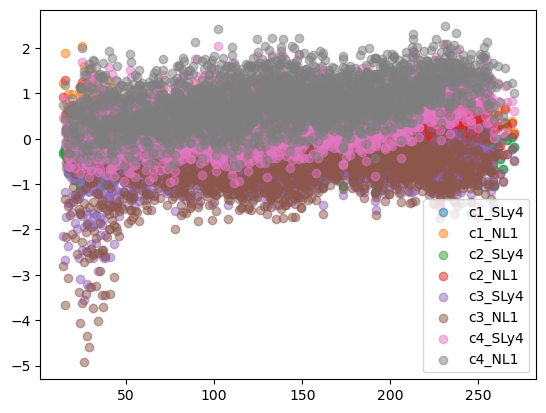

In [5]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y =masses_truth.values -  models_output_df[key].values, label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [6]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.to_latex())

              mean       std  res_mean   res_std      rmse
c1_SLy4 -11.136117  0.997681 -0.138479  0.340072  0.367186
c1_NL1  -11.557858  0.906293  0.283262  0.350907  0.450969
c2_SLy4 -11.130510  1.000848 -0.144085  0.340962  0.370156
c2_NL1  -11.499792  0.933992  0.225196  0.338851  0.406857
c3_SLy4 -10.813755  1.168409 -0.460840  0.465186  0.654807
c3_NL1  -10.854550  1.301794 -0.420046  0.632991  0.759681
c4_SLy4 -11.731693  1.049045  0.457098  0.517888  0.690758
c4_NL1  -12.101409  1.067444  0.826813  0.524817  0.979313
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4 & -11.136117 & 0.997681 & -0.138479 & 0.340072 & 0.367186 \\
c1_NL1 & -11.557858 & 0.906293 & 0.283262 & 0.350907 & 0.450969 \\
c2_SLy4 & -11.130510 & 1.000848 & -0.144085 & 0.340962 & 0.370156 \\
c2_NL1 & -11.499792 & 0.933992 & 0.225196 & 0.338851 & 0.406857 \\
c3_SLy4 & -10.813755 & 1.168409 & -0.460840 & 0.465186 & 0.654807 \\
c3_NL1 & -10.854550 & 1.301794 & -0.420046 & 0.632991 & 0.7

### Scenario - 1 good model 7 bad models

In [7]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1g7b"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 7
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(masses_truth.shape[0]) * 0.1

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

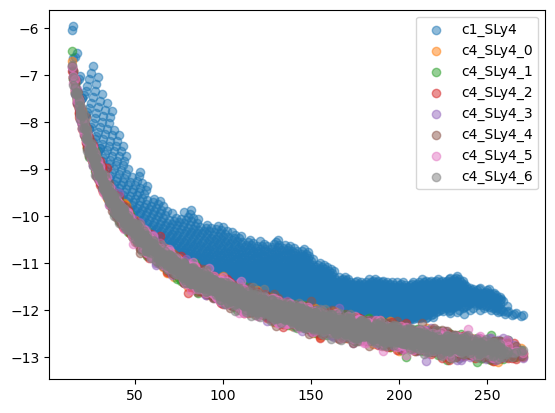

In [8]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [9]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                mean       std  res_mean   res_std      rmse
c1_SLy4   -11.136117  0.997681 -0.138479  0.340072  0.367186
c4_SLy4_0 -11.735015  1.050754  0.460420  0.524309  0.697773
c4_SLy4_1 -11.733042  1.054215  0.458446  0.526789  0.698340
c4_SLy4_2 -11.733808  1.057355  0.459212  0.527399  0.699304
c4_SLy4_3 -11.730896  1.054633  0.456300  0.525822  0.696203
c4_SLy4_4 -11.730849  1.052634  0.456253  0.526768  0.696887
c4_SLy4_5 -11.733500  1.054551  0.458904  0.527546  0.699213
c4_SLy4_6 -11.732027  1.055402  0.457431  0.528990  0.699338
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4 & -11.14 & 1.00 & -0.14 & 0.34 & 0.37 \\
c4_SLy4_0 & -11.74 & 1.05 & 0.46 & 0.52 & 0.70 \\
c4_SLy4_1 & -11.73 & 1.05 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_2 & -11.73 & 1.06 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_3 & -11.73 & 1.05 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_4 & -11.73 & 1.05 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_5 & -11.73 & 1.05 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_6 & -11.73 & 1.06 & 0.46 

### Scenario - 4 good models 4 bad models

In [10]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "4g4b"
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 4
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(masses_truth.shape[0]) * 0.1

n_class_4 = 4
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(masses_truth.shape[0]) * 0.1
    

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

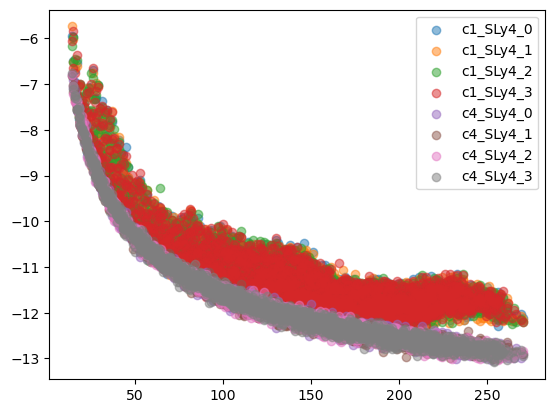

In [11]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [12]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

                mean       std  res_mean   res_std      rmse
c1_SLy4_0 -11.139439  0.999597 -0.135157  0.350111  0.375294
c1_SLy4_1 -11.137465  1.003051 -0.137131  0.353293  0.378974
c1_SLy4_2 -11.138231  1.006261 -0.136365  0.353950  0.379309
c1_SLy4_3 -11.135319  1.003970 -0.139277  0.353217  0.379684
c4_SLy4_0 -11.730849  1.052634  0.456253  0.526768  0.696887
c4_SLy4_1 -11.733500  1.054551  0.458904  0.527546  0.699213
c4_SLy4_2 -11.732027  1.055402  0.457431  0.528990  0.699338
c4_SLy4_3 -11.732370  1.052740  0.457775  0.527278  0.698269
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4_0 & -11.14 & 1.00 & -0.14 & 0.35 & 0.38 \\
c1_SLy4_1 & -11.14 & 1.00 & -0.14 & 0.35 & 0.38 \\
c1_SLy4_2 & -11.14 & 1.01 & -0.14 & 0.35 & 0.38 \\
c1_SLy4_3 & -11.14 & 1.00 & -0.14 & 0.35 & 0.38 \\
c4_SLy4_0 & -11.73 & 1.05 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_1 & -11.73 & 1.05 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_2 & -11.73 & 1.06 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_3 & -11.73 & 1.05 & 

### Scenario - 7 good models 1 bad model

In [17]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "7g1b"

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 7
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(masses_truth.shape[0]) * 0.1

n_class_4 = 1
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(masses_truth.shape[0]) * 0.1
    

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

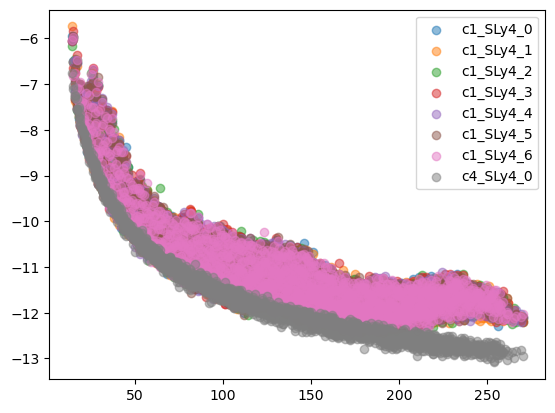

In [18]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [19]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

                mean       std  res_mean   res_std      rmse
c1_SLy4_0 -11.139439  0.999597 -0.135157  0.350111  0.375294
c1_SLy4_1 -11.137465  1.003051 -0.137131  0.353293  0.378974
c1_SLy4_2 -11.138231  1.006261 -0.136365  0.353950  0.379309
c1_SLy4_3 -11.135319  1.003970 -0.139277  0.353217  0.379684
c1_SLy4_4 -11.135272  1.001739 -0.139323  0.354251  0.380664
c1_SLy4_5 -11.137924  1.003643 -0.136672  0.355098  0.380492
c1_SLy4_6 -11.136450  1.004158 -0.138146  0.356175  0.382027
c4_SLy4_0 -11.732370  1.052740  0.457775  0.527278  0.698269
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4_0 & -11.14 & 1.00 & -0.14 & 0.35 & 0.38 \\
c1_SLy4_1 & -11.14 & 1.00 & -0.14 & 0.35 & 0.38 \\
c1_SLy4_2 & -11.14 & 1.01 & -0.14 & 0.35 & 0.38 \\
c1_SLy4_3 & -11.14 & 1.00 & -0.14 & 0.35 & 0.38 \\
c1_SLy4_4 & -11.14 & 1.00 & -0.14 & 0.35 & 0.38 \\
c1_SLy4_5 & -11.14 & 1.00 & -0.14 & 0.36 & 0.38 \\
c1_SLy4_6 & -11.14 & 1.00 & -0.14 & 0.36 & 0.38 \\
c4_SLy4_0 & -11.73 & 1.05

### Scenario - 1 model perfect 7 models bad

In [20]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1p7b"
corruption_noise_Mass=1/3

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = masses_truth + np.random.randn(masses_truth.shape[0]) * 0.001

n_class_4 = 7
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(masses_truth.shape[0]) * 0.1

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

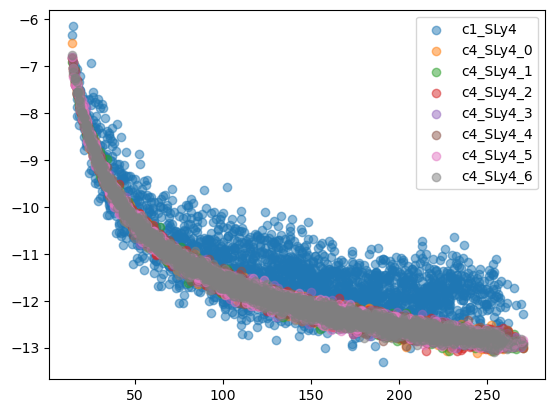

In [21]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [22]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

                mean       std  res_mean   res_std      rmse
c1_SLy4   -11.274629  0.990847  0.000033  0.000994  0.000994
c4_SLy4_0 -11.733042  1.054215  0.458446  0.526789  0.698340
c4_SLy4_1 -11.733808  1.057355  0.459212  0.527399  0.699304
c4_SLy4_2 -11.730896  1.054633  0.456300  0.525822  0.696203
c4_SLy4_3 -11.730849  1.052634  0.456253  0.526768  0.696887
c4_SLy4_4 -11.733500  1.054551  0.458904  0.527546  0.699213
c4_SLy4_5 -11.732027  1.055402  0.457431  0.528990  0.699338
c4_SLy4_6 -11.732370  1.052740  0.457775  0.527278  0.698269
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4 & -11.27 & 0.99 & 0.00 & 0.00 & 0.00 \\
c4_SLy4_0 & -11.73 & 1.05 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_1 & -11.73 & 1.06 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_2 & -11.73 & 1.05 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_3 & -11.73 & 1.05 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_4 & -11.73 & 1.05 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_5 & -11.73 & 1.06 & 0.46 & 0.53 & 0.70 \\
c4_SLy4_6 & -11.73 & 1.05 & 0.46 &

## PCA - Analysis

### Raw model output  -  not standardized

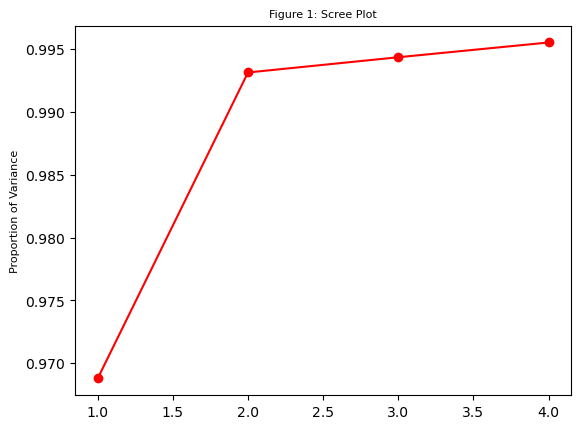

In [23]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(models_output_df[models_output.keys()])

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

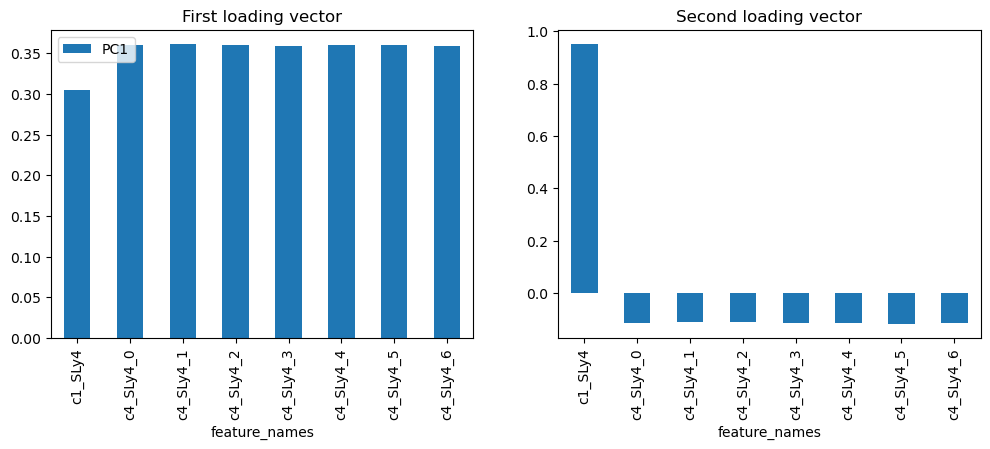

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4        0.304615  0.952458  0.001646  0.003031
c4_SLy4_0      0.359904 -0.114211 -0.450550 -0.025725
c4_SLy4_1      0.360969 -0.112959 -0.333089 -0.565300
c4_SLy4_2      0.360086 -0.111761  0.387221 -0.280461
c4_SLy4_3      0.359327 -0.115066 -0.374499  0.701553
c4_SLy4_4      0.360033 -0.116166  0.358065  0.019871
c4_SLy4_5      0.360268 -0.118604  0.508130  0.295528
c4_SLy4_6      0.359423 -0.117163 -0.097253 -0.145593


In [24]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

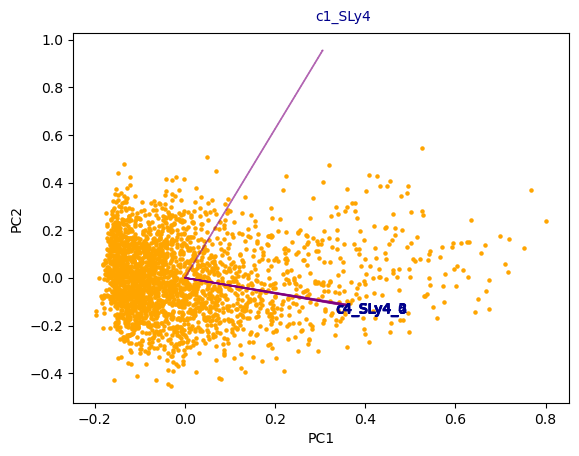

In [25]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))
plt.savefig("Biplot_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Raw model output -  standardized

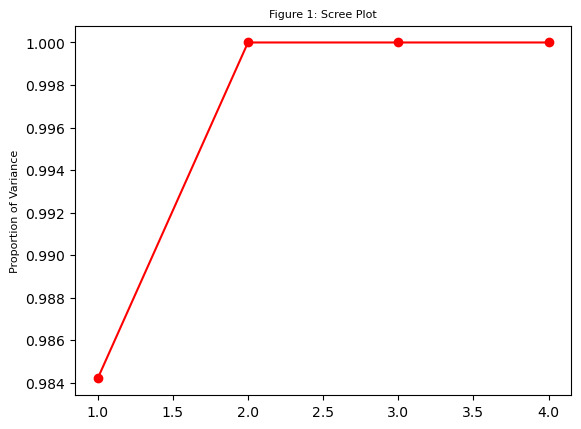

In [14]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(models_output_df[models_output.keys()])
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

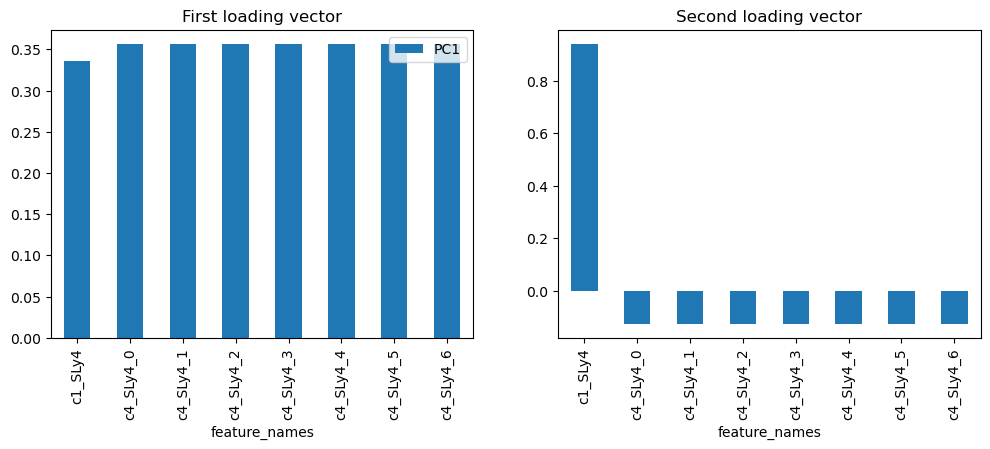

                    PC1       PC2       PC3           PC4
feature_names                                            
c1_SLy4        0.335808  0.941931 -0.000000  0.000000e+00
c4_SLy4_0      0.356016 -0.126923 -0.925820 -1.941078e-16
c4_SLy4_1      0.356016 -0.126923  0.154303  9.128709e-01
c4_SLy4_2      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_3      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_4      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_5      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_6      0.356016 -0.126923  0.154303 -1.825742e-01


In [15]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

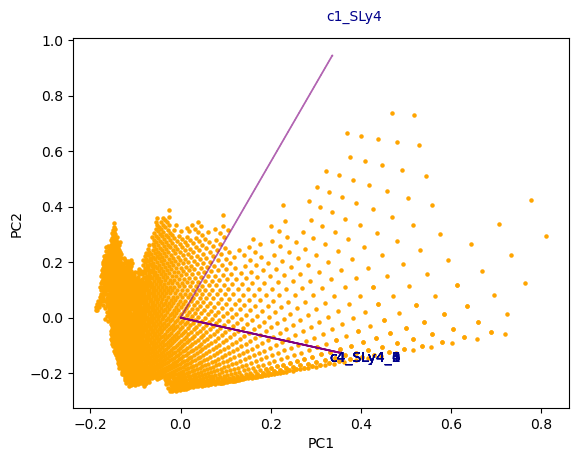

In [16]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Residuals - not standardized

In [55]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 
np.corrcoef(residuals.T)

array([[ 1.        , -0.03438014, -0.02965876, -0.03445698, -0.0316818 ,
        -0.0323513 , -0.03098116, -0.0354998 ],
       [-0.03438014,  1.        ,  0.96364325,  0.96414591,  0.96413814,
         0.96317014,  0.96321517,  0.96522021],
       [-0.02965876,  0.96364325,  1.        ,  0.96364073,  0.96325216,
         0.96356181,  0.96301385,  0.96433905],
       [-0.03445698,  0.96414591,  0.96364073,  1.        ,  0.96270806,
         0.96503558,  0.96480633,  0.96439704],
       [-0.0316818 ,  0.96413814,  0.96325216,  0.96270806,  1.        ,
         0.96391925,  0.96364462,  0.96399336],
       [-0.0323513 ,  0.96317014,  0.96356181,  0.96503558,  0.96391925,
         1.        ,  0.96464574,  0.96560946],
       [-0.03098116,  0.96321517,  0.96301385,  0.96480633,  0.96364462,
         0.96464574,  1.        ,  0.9641011 ],
       [-0.0354998 ,  0.96522021,  0.96433905,  0.96439704,  0.96399336,
         0.96560946,  0.9641011 ,  1.        ]])

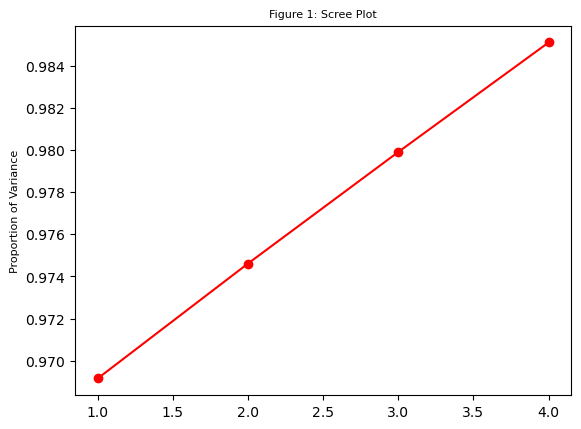

In [56]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(residuals)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

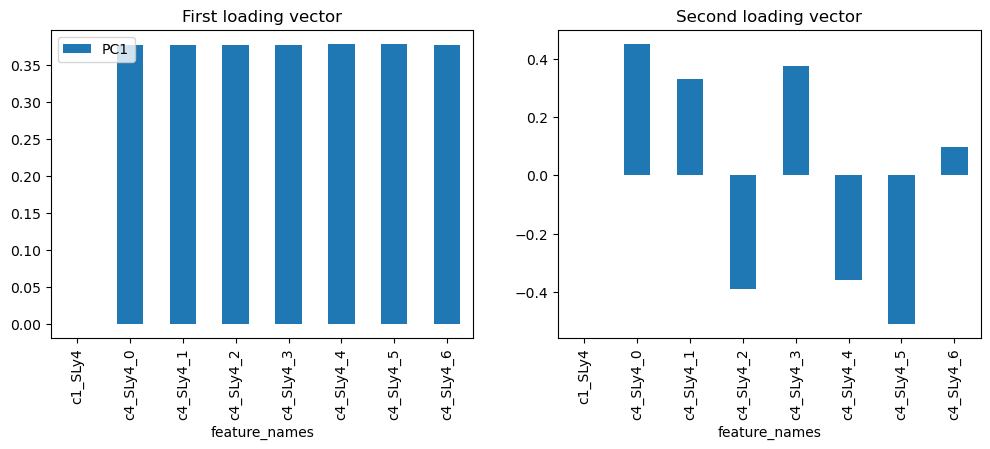

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4       -0.000024  0.000001 -0.000015 -0.000233
c4_SLy4_0      0.377616  0.450801  0.016758  0.637406
c4_SLy4_1      0.377942  0.330496  0.585104 -0.598132
c4_SLy4_2      0.376984 -0.387916  0.276748  0.274667
c4_SLy4_3      0.377497  0.376282 -0.693826 -0.287865
c4_SLy4_4      0.378301 -0.357758 -0.026186 -0.132002
c4_SLy4_5      0.379206 -0.507869 -0.286571 -0.111448
c4_SLy4_6      0.378202  0.097783  0.128765  0.218628


In [57]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

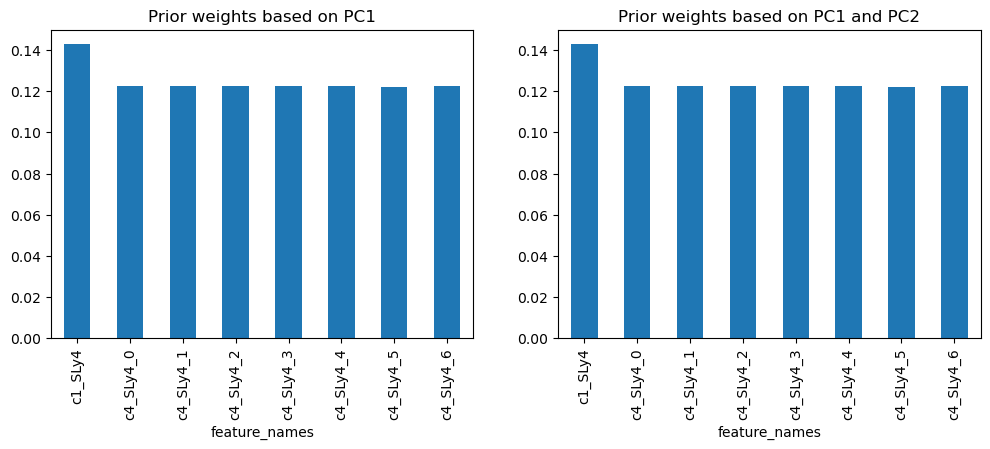

                    PC1       PC2       PC3       PC4       PW1            W2  \
feature_names                                                                   
c1_SLy4       -0.000024  0.000001 -0.000015 -0.000233  0.142857  5.752091e-10   
c4_SLy4_0      0.377616  0.450801  0.016758  0.637406  0.122487  1.429337e-01   
c4_SLy4_1      0.377942  0.330496  0.585104 -0.598132  0.122451  1.426519e-01   
c4_SLy4_2      0.376984 -0.387916  0.276748  0.274667  0.122555  1.421636e-01   
c4_SLy4_3      0.377497  0.376282 -0.693826 -0.287865  0.122499  1.424985e-01   
c4_SLy4_4      0.378301 -0.357758 -0.026186 -0.132002  0.122413  1.430267e-01   
c4_SLy4_5      0.379206 -0.507869 -0.286571 -0.111448  0.122315  1.444364e-01   
c4_SLy4_6      0.378202  0.097783  0.128765  0.218628  0.122423  1.422890e-01   

                    PW2  
feature_names            
c1_SLy4        0.142857  
c4_SLy4_0      0.122438  
c4_SLy4_1      0.122478  
c4_SLy4_2      0.122548  
c4_SLy4_3      0.122500  
c4_SLy4

In [58]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = (1 - loadings["PC1"] ** 2) / np.sum((1 - loadings["PC1"] ** 2))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 - loadings["W2"]) / np.sum((1 - loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
plt.savefig("PC_ToyResid_weightsV1_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

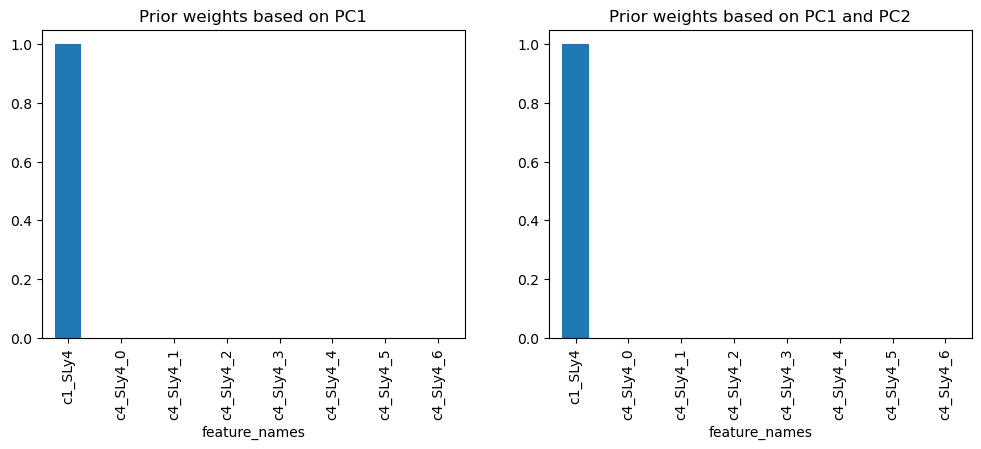

                    PC1       PC2       PC3       PC4           PW1  \
feature_names                                                         
c1_SLy4       -0.000024  0.000001 -0.000015 -0.000233  1.000000e+00   
c4_SLy4_0      0.377616  0.450801  0.016758  0.637406  4.056566e-09   
c4_SLy4_1      0.377942  0.330496  0.585104 -0.598132  4.049571e-09   
c4_SLy4_2      0.376984 -0.387916  0.276748  0.274667  4.070187e-09   
c4_SLy4_3      0.377497  0.376282 -0.693826 -0.287865  4.059136e-09   
c4_SLy4_4      0.378301 -0.357758 -0.026186 -0.132002  4.041897e-09   
c4_SLy4_5      0.379206 -0.507869 -0.286571 -0.111448  4.022632e-09   
c4_SLy4_6      0.378202  0.097783  0.128765  0.218628  4.044003e-09   

                         W2           PW2  
feature_names                              
c1_SLy4        5.752091e-10  1.000000e+00  
c4_SLy4_0      1.429337e-01  4.024306e-09  
c4_SLy4_1      1.426519e-01  4.032256e-09  
c4_SLy4_2      1.421636e-01  4.046105e-09  
c4_SLy4_3      1.424985e-

In [59]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = ( 1 / (loadings["PC1"] ** 2)) / np.sum((1/ (loadings["PC1"] ** 2)))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 / loadings["W2"]) / np.sum(( 1/ loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
plt.savefig("PC_ToyResid_weightsV2_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

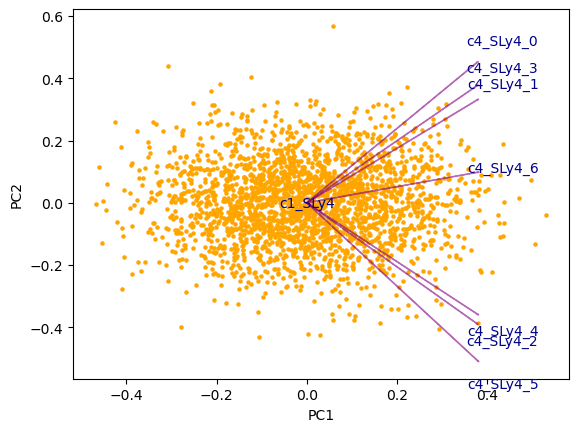

In [60]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

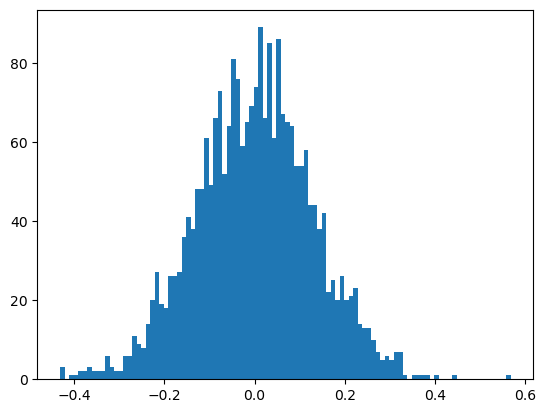

-0.4316442972503979


In [61]:
PCA_2_scaled = X_pca[:,1] / (X_pca[:,1].max() - X_pca[:,1].min())
plt.hist(PCA_2_scaled, bins = 100)
plt.show()
print(PCA_2_scaled.min())

### Residuals - standardized

In [39]:
residuals =masses_truth.values[:,None] - models_output_df[models_output.keys()].values
np.corrcoef(residuals.T)

array([[1.        , 0.62778636, 0.63082676, 0.63039568, 0.63205913,
        0.63182642, 0.63350399, 0.63375794],
       [0.62778636, 1.        , 0.96333256, 0.96362353, 0.96340014,
        0.96324756, 0.96378094, 0.96404966],
       [0.63082676, 0.96333256, 1.        , 0.96364325, 0.96414591,
        0.96413814, 0.96317014, 0.96321517],
       [0.63039568, 0.96362353, 0.96364325, 1.        , 0.96364073,
        0.96325216, 0.96356181, 0.96301385],
       [0.63205913, 0.96340014, 0.96414591, 0.96364073, 1.        ,
        0.96270806, 0.96503558, 0.96480633],
       [0.63182642, 0.96324756, 0.96413814, 0.96325216, 0.96270806,
        1.        , 0.96391925, 0.96364462],
       [0.63350399, 0.96378094, 0.96317014, 0.96356181, 0.96503558,
        0.96391925, 1.        , 0.96464574],
       [0.63375794, 0.96404966, 0.96321517, 0.96301385, 0.96480633,
        0.96364462, 0.96464574, 1.        ]])

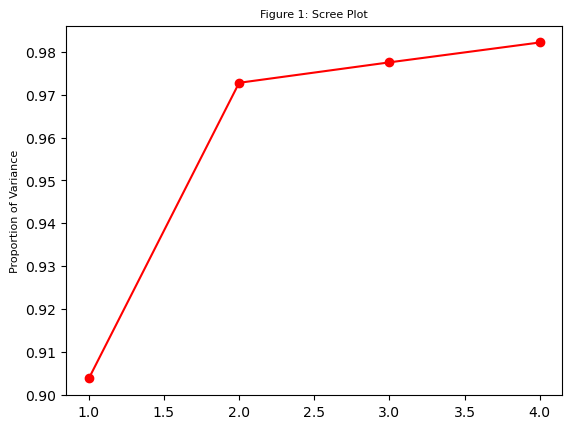

In [40]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(residuals)
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

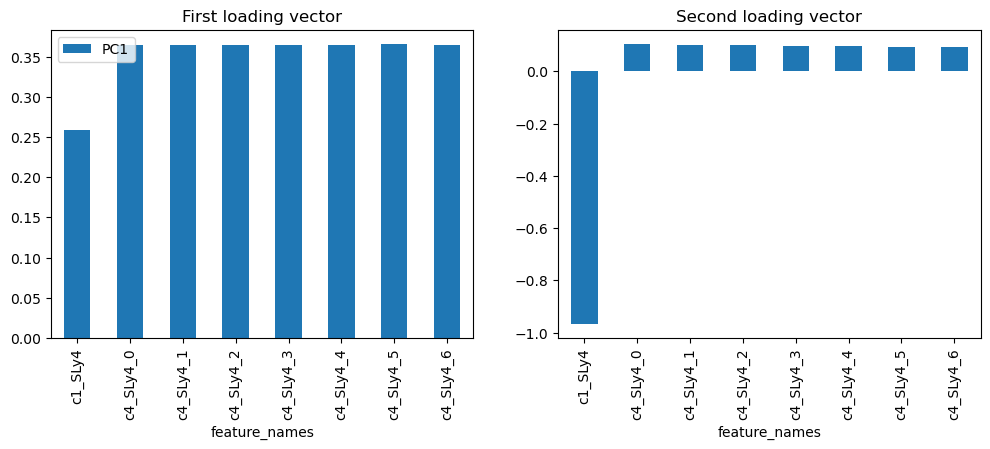

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4        0.259002 -0.965837  0.003822  0.004547
c4_SLy4_0      0.364892  0.104596 -0.010321  0.235335
c4_SLy4_1      0.365012  0.098946  0.449792 -0.047038
c4_SLy4_2      0.364951  0.099586  0.308161  0.676521
c4_SLy4_3      0.365163  0.097015 -0.416206  0.143766
c4_SLy4_4      0.365011  0.096927  0.460540 -0.617799
c4_SLy4_5      0.365234  0.094389 -0.364954 -0.147464
c4_SLy4_6      0.365206  0.093777 -0.429053 -0.246197


In [41]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

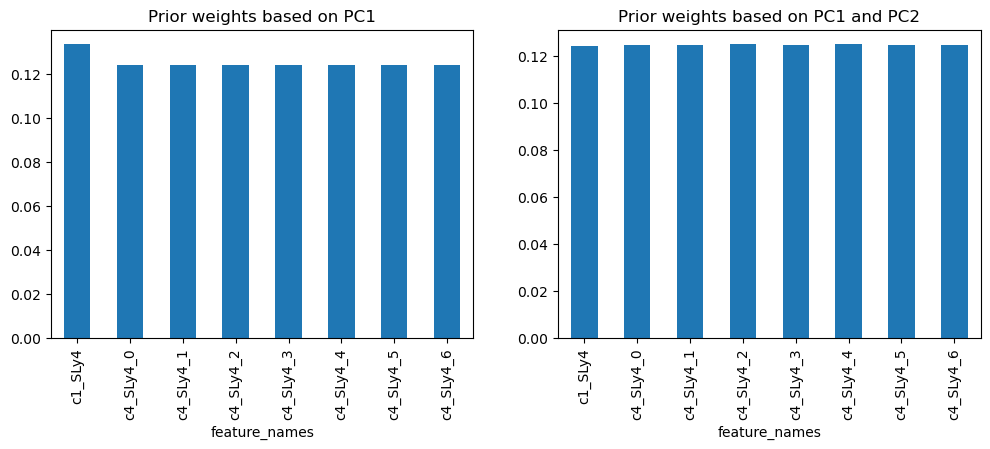

                    PC1       PC2       PC3       PC4       PW1        W2  \
feature_names                                                               
c1_SLy4        0.259002 -0.965837  0.003822  0.004547  0.133274  0.128496   
c4_SLy4_0      0.364892  0.104596 -0.010321  0.235335  0.123836  0.124478   
c4_SLy4_1      0.365012  0.098946  0.449792 -0.047038  0.123824  0.124477   
c4_SLy4_2      0.364951  0.099586  0.308161  0.676521  0.123830  0.124445   
c4_SLy4_3      0.365163  0.097015 -0.416206  0.143766  0.123808  0.124553   
c4_SLy4_4      0.365011  0.096927  0.460540 -0.617799  0.123824  0.124448   
c4_SLy4_5      0.365234  0.094389 -0.364954 -0.147464  0.123801  0.124565   
c4_SLy4_6      0.365206  0.093777 -0.429053 -0.246197  0.123804  0.124538   

                    PW2  
feature_names            
c1_SLy4        0.124501  
c4_SLy4_0      0.125075  
c4_SLy4_1      0.125075  
c4_SLy4_2      0.125079  
c4_SLy4_3      0.125064  
c4_SLy4_4      0.125079  
c4_SLy4_5      0.1250

In [42]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = (1 - loadings["PC1"] ** 2) / np.sum((1 - loadings["PC1"] ** 2))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 - loadings["W2"]) / np.sum((1 - loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
#plt.savefig("PC_ToyResid_weightsV1.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

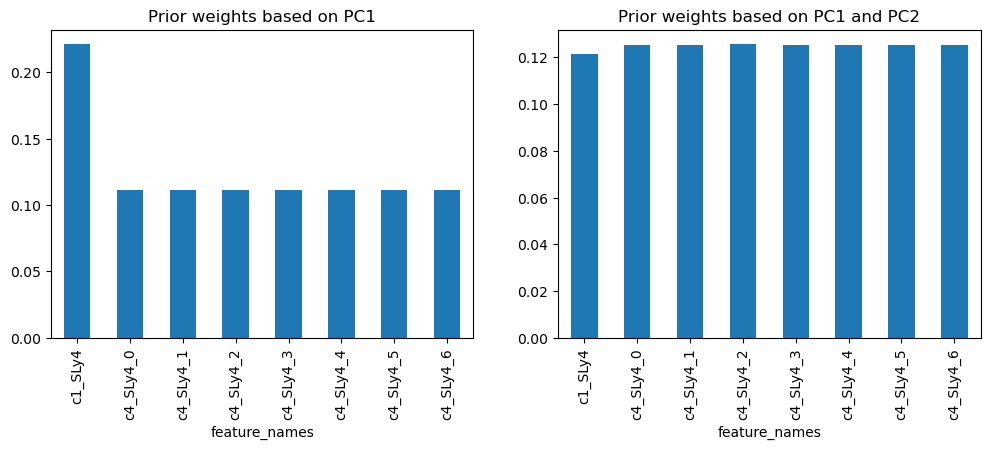

                    PC1       PC2       PC3       PC4       PW1        W2  \
feature_names                                                               
c1_SLy4        0.259002 -0.965837  0.003822  0.004547  0.221073  0.128496   
c4_SLy4_0      0.364892  0.104596 -0.010321  0.235335  0.111382  0.124478   
c4_SLy4_1      0.365012  0.098946  0.449792 -0.047038  0.111309  0.124477   
c4_SLy4_2      0.364951  0.099586  0.308161  0.676521  0.111346  0.124445   
c4_SLy4_3      0.365163  0.097015 -0.416206  0.143766  0.111217  0.124553   
c4_SLy4_4      0.365011  0.096927  0.460540 -0.617799  0.111309  0.124448   
c4_SLy4_5      0.365234  0.094389 -0.364954 -0.147464  0.111173  0.124565   
c4_SLy4_6      0.365206  0.093777 -0.429053 -0.246197  0.111191  0.124538   

                    PW2  
feature_names            
c1_SLy4        0.121586  
c4_SLy4_0      0.125511  
c4_SLy4_1      0.125511  
c4_SLy4_2      0.125544  
c4_SLy4_3      0.125435  
c4_SLy4_4      0.125540  
c4_SLy4_5      0.1254

In [43]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = ( 1 / (loadings["PC1"] ** 2)) / np.sum((1/ (loadings["PC1"] ** 2)))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 / loadings["W2"]) / np.sum(( 1/ loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
#plt.savefig("PC_ToyResid_weightsV2.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

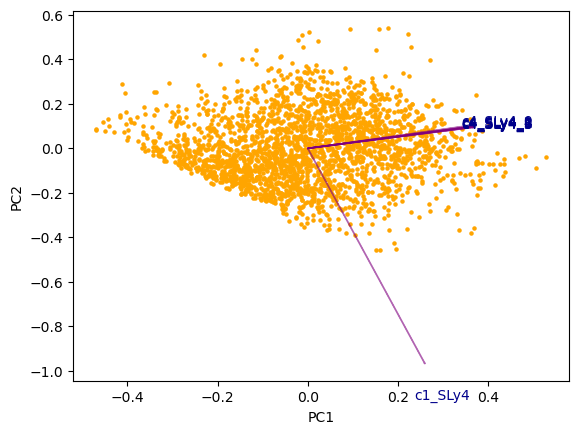

In [44]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()